# Mall Customers: Unsupervised Learning with K-Means Clustering

## 1. Data Exploration

### 1.1 Load dataset and preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mall_customers = pd.read_csv('Mall_Customers.csv')
mall_customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


I don't like how the columns are named. Let's simplify it.

In [3]:
mall_customers.columns = ['id', 'gender', 'age', 'annual_income', 'spending_score']

ID is meaningless in the model training since it is not really a feature. Thus, we can drop the  ID column.

In [4]:
mall_customers.drop(columns='id', axis=1, inplace=True)

Since the gender columns contain data with object datatypes (Male, Female), I would like to use Label Encoder to turn the data into numerical.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
mall_customers['gender'] = le.fit_transform(mall_customers['gender'])
mall_customers.head()

,gender,age,annual_income,spending_score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


As a result, my gender column is now binary:
- Male: 1
- Female: 0

### 1.2 Exploratory data analysis

In [6]:
mall_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   gender          200 non-null    int32
 1   age             200 non-null    int64
 2   annual_income   200 non-null    int64
 3   spending_score  200 non-null    int64
dtypes: int32(1), int64(3)
memory usage: 5.6 KB


The mall customers dataset contains 200 instances and zero null values.

In [7]:
mall_customers.describe()

,gender,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


Here we can see that gender is a binary (0, 1), age range from 18 - 70 years old, annual income of $15,000 to $137,000, and spending score 1 to 99.

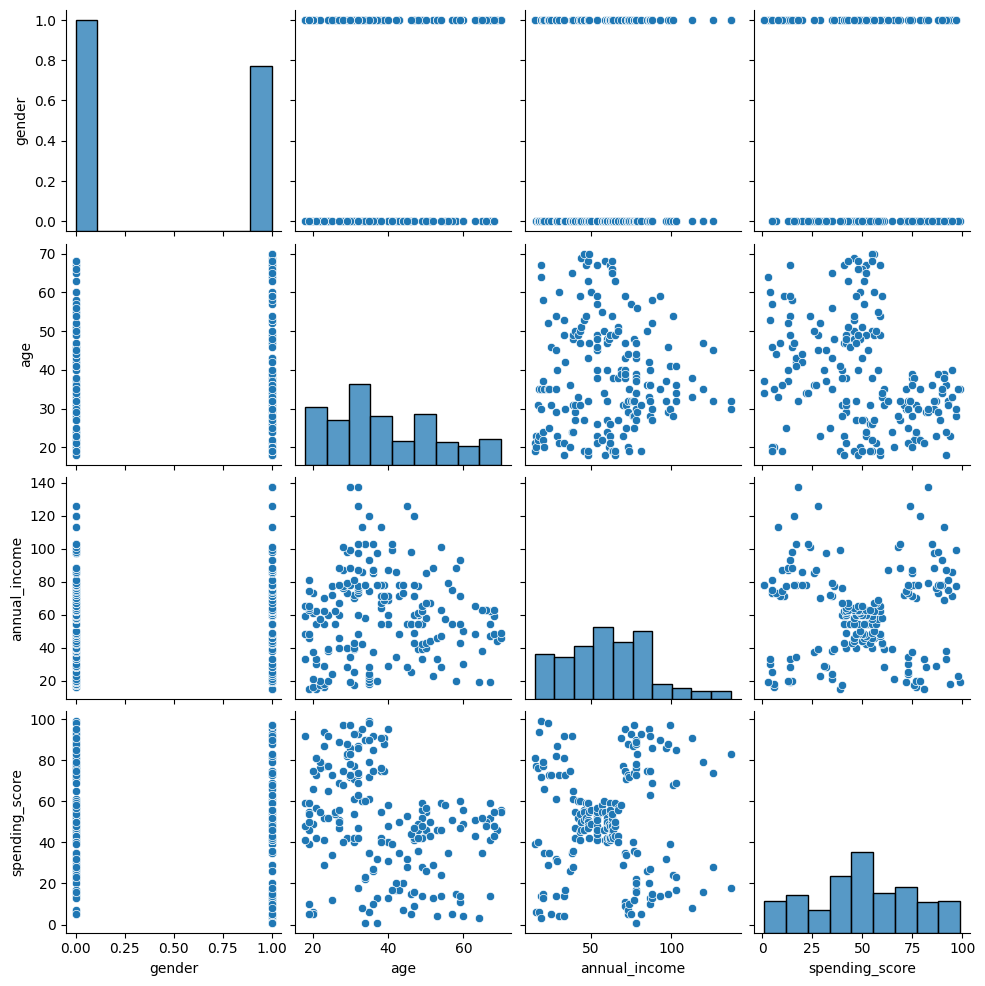

In [8]:
# Plot pairwise relationships in a dataset
sns.pairplot(mall_customers)
plt.show()

Observations:
- Gender: binary (0 or 1), which might not provide significant differentiation on its own for clustering purposes, as it lacks the continuous variability needed for effective clustering.
- Age: has a wide range of values and shows some variability in the data. However, the scatter plots involving age don’t show very clear separable patterns, suggesting it might not be the most effective standalone feature for clustering.
- Annual Income: shows a wide range and clear variability, and the scatter plots involving annual income and spending score show distinct patterns. This indicates that annual income is a promising feature for clustering.
- Spending Score: also shows a wide range and clear variability. The scatter plots involving spending score, especially with annual income, display distinct clusters.

## 2. Data Preprocessing

### 2.1 Feature selection

For feature selection, feature annual income and spending score will be used because it exhibit clear separable patterns until you can even estimate the number of segments as well as location of the centroid.

Plus, in the context of customer segmentation, annual income and spending score are highly relevant features as they directly relate to purchasing power and customer behavior.

In [9]:
# Select the annual income and spending score for clustering
X = mall_customers[['annual_income', 'spending_score']]
X.head()

,annual_income,spending_score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


### 2.2 Feature scaling

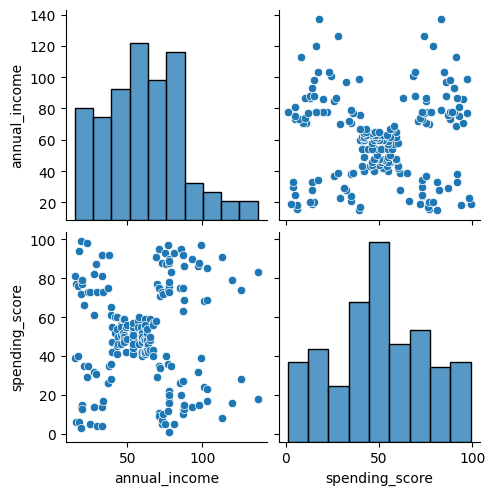

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X, columns=X.columns)
sns.pairplot(X_scaled)

## 3. Choosing Number of Clusters

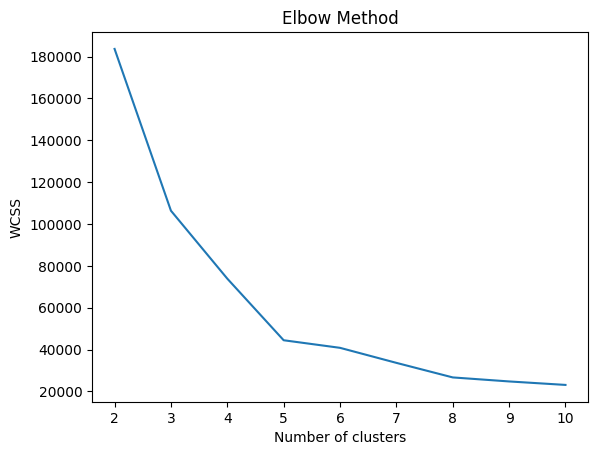

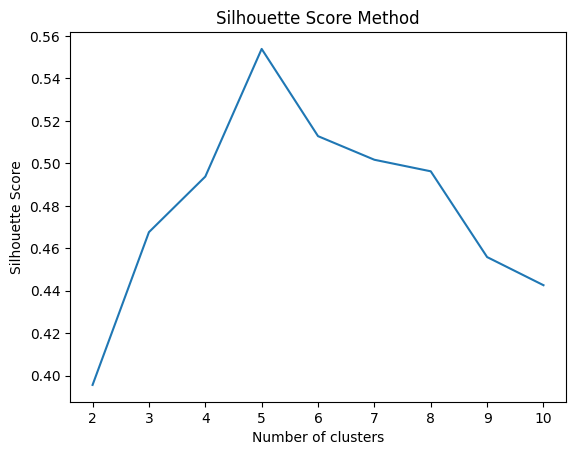

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss=[]
silhoutte_scores=[]

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhoutte_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(2, 11), silhoutte_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

It is obvious that the optimal number of clusters is 5 because it is the elbow with highest silhouette score.

## 4. K-Means Clustering

In [12]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k)
cluster_labels = kmeans.fit_predict(X_scaled)
X['cluster'] = cluster_labels
X.head()

,annual_income,spending_score,cluster
0,15,39,3
1,15,81,2
2,16,6,3
3,16,77,2
4,17,40,3


## 5. Cluster Analysis

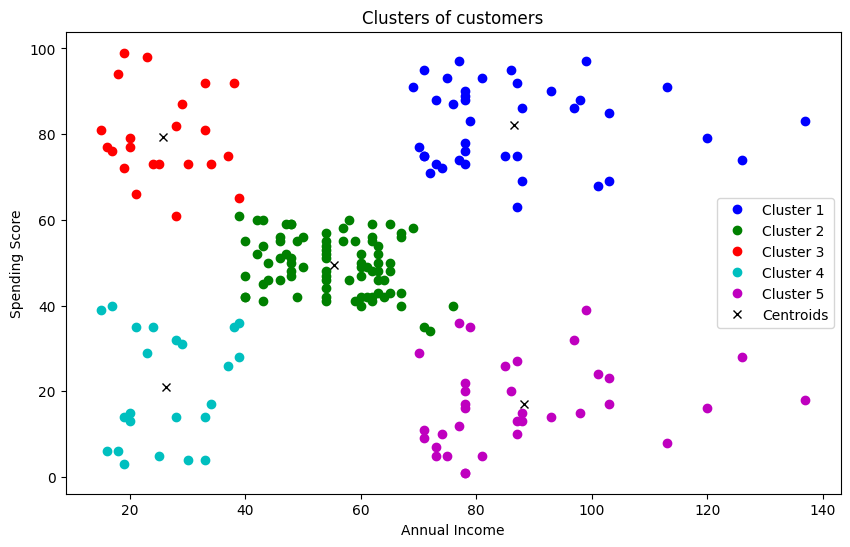

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(X[X['cluster'] == 0]['annual_income'], X[X['cluster'] == 0]['spending_score'], 'bo', label='Cluster 1')
plt.plot(X[X['cluster'] == 1]['annual_income'], X[X['cluster'] == 1]['spending_score'], 'go', label='Cluster 2')
plt.plot(X[X['cluster'] == 2]['annual_income'], X[X['cluster'] == 2]['spending_score'], 'ro', label='Cluster 3')
plt.plot(X[X['cluster'] == 3]['annual_income'], X[X['cluster'] == 3]['spending_score'], 'co', label='Cluster 4')
plt.plot(X[X['cluster'] == 4]['annual_income'], X[X['cluster'] == 4]['spending_score'], 'mo', label='Cluster 5')
plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 'kx', label='Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

- Cluster 1: High annual income, high spending score
- Cluster 2: Average annual income, average spending score
- Cluster 3: Low annual income, high spending score
- Cluster 4: Low annual income, low spending score
- Cluster 5: High annual income, low spending score

## 6. Evaluation and Interpretation

### 6.1 Cluster 1: High Annual Income, High Spending Score

Characteristics: 
- Customers in this cluster have high annual incomes and high spending scores, indicating they are willing and able to spend money on high-end products or services.

Strategies:
- Premium Loyalty Programs: Create exclusive loyalty programs with premium benefits to encourage repeat purchases.
- High-End Product Offerings: Introduce and market luxury and high-end products or services targeted at these customers.
- Personalized Marketing: Use personalized marketing campaigns to showcase exclusive deals and new arrivals.
- VIP Events: Organize VIP events and experiences that cater to their preferences and lifestyle.

### 6.2 Cluster 2: Average Annual Income, Average Spending Score

Characteristics: 
- These customers have average annual incomes and moderate spending scores.

Strategies:
- Value Promotions: Offer value-for-money promotions and discounts to increase spending.
- Bundling: Create product bundles that provide more value and encourage higher spending.
- Membership Programs: Develop membership programs with moderate benefits to foster customer loyalty.
- Feedback and Improvement: Regularly collect feedback to improve product offerings and customer satisfaction.

### 6.3 Cluster 3: Low Annual Income, High Spending Score

Characteristics: 
- Customers in this cluster have low annual incomes but high spending scores, suggesting they prioritize spending despite a lower income.

Strategies:
- Installment Payment Plans: Offer installment payment options or financing plans to make it easier for them to purchase high-value items.
- Discounts and Offers: Provide frequent discounts and special offers to make products more affordable.
- Targeted Marketing: Use targeted marketing to promote essential and value-for-money products that appeal to this group.
- Loyalty Rewards: Implement loyalty programs that offer significant rewards for frequent purchases.

### 6.4 Cluster 4: Low Annual Income, Low Spending Score

Characteristics: 
- These customers have low annual incomes and low spending scores, indicating they are more price-sensitive and cautious with spending.

Strategies:
- Budget-Friendly Options: Focus on offering budget-friendly and essential products to cater to their needs.
- Discount Campaigns: Run regular discount campaigns and flash sales to attract these cost-conscious customers.
- Community Engagement: Engage with this community through social initiatives and community-building activities.
- Educational Content: Provide educational content and tips on how to get the most value from products.

### 6.5 Cluster 5: High Annual Income, Low Spending Score

Characteristics: 
- Customers in this cluster have high annual incomes but low spending scores, indicating they have the potential to spend more but currently do not.

Strategies:
- Incentivize Spending: Offer incentives for increased spending, such as tiered loyalty rewards or cashback offers.
- Upselling and Cross-Selling: Implement upselling and cross-selling strategies to encourage higher spending.
- Exclusive Previews: Provide exclusive previews and early access to new products or collections to entice these customers.
- Analyze Barriers: Conduct surveys or focus groups to understand the barriers to higher spending and address them accordingly.